In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
dist_central = np.loadtxt("CustDist_WHCentral.csv", skiprows=1, delimiter=",")[:,1:]
xy_central   = np.loadtxt("CustXY_WHCentral.csv", skiprows=1, delimiter=",")[:,1:].T

dist_corner  = np.loadtxt("CustDist_WHCorner.csv", skiprows=1, delimiter=",")[:,1:]
xy_corner    = np.loadtxt("CustXY_WHCorner.csv", skiprows=1, delimiter=",")[:,1:].T

orders       = np.loadtxt("CustOrd.csv", skiprows=1, delimiter=",")[:,1]

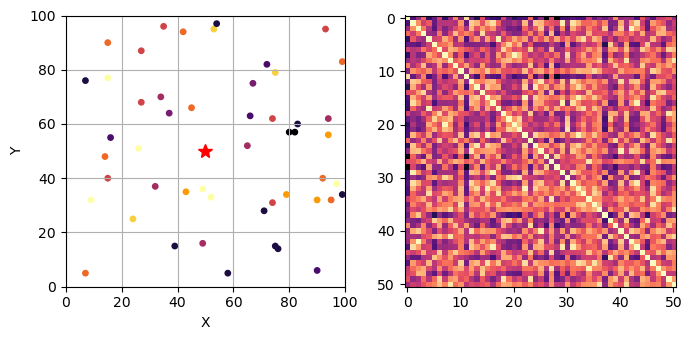

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_central[0][1:], xy_central[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_central[0][0], xy_central[1][0], ls="", marker="*", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()

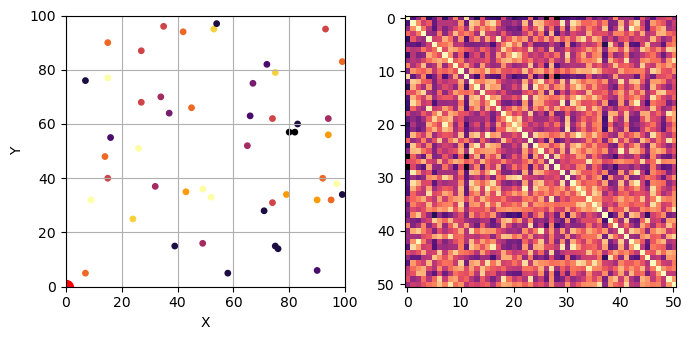

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3.5))

ax[0].set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))

ax[0].scatter(xy_corner[0][1:], xy_corner[1][1:], marker="o", s=15, c=orders[1:], cmap="inferno_r")
ax[0].plot(xy_corner[0][0], xy_corner[1][0], ls="", marker="o", ms=10, c="red")
ax[0].grid()

im = ax[1].imshow(dist_corner, cmap="magma_r")
# fig.colorbar(im, ax=ax[1])#, label='Interactive colorbar')
plt.tight_layout()

In [25]:
import random

from deap import base
from deap import creator
from deap import tools

In [342]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

IND_SIZE = 10

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(1, IND_SIZE+1), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [343]:
def evaluate(individual, distances, orders, max_capacity=1000):
    
    dist = distances[0, individual[0]]
    capacity = max_capacity - orders[individual[0]]
    
    for i, f in zip(individual[:-1], individual[1:]):
        if capacity < orders[f]:
            dist += distances[i][0]
            capacity = max_capacity
            dist += distances[0][f]
            # print("Ups, go back")
        else:
            dist += distances[i][f]
        
        capacity -= orders[f]
        # print(f"Went from {i} to {f} and capacity is now {capacity} and dist is {dist}")        
    dist += distances[0, individual[-1]]
    return (dist,)
toolbox.register("evaluate", evaluate)

In [629]:
def plot_route(route, coords, orders, max_capacity=1000):
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))

    ax.set(xlabel="X", ylabel="Y", xlim=(0,100), ylim=(0,100))
    ax.scatter(coords[:,0], coords[:,1], marker="o", s=15, c=orders, cmap="inferno_r")
    ax.plot(coords[0][0], coords[0][1], ls="", marker="o", ms=10, c="red")
    ax.grid()

    capacity = max_capacity - orders[route[0]]
    ax.annotate("", xytext=coords[0], xy=coords[route[0]], arrowprops=dict(arrowstyle="->"))
    
    for i, f in zip(route, route[1:]):
        if capacity < orders[f]:
            capacity = max_capacity
            ax.annotate("", xytext=coords[i], xy=coords[0], arrowprops=dict(arrowstyle="->"))
            ax.annotate("", xytext=coords[0], xy=coords[f], arrowprops=dict(arrowstyle="->"))
            capacity -= orders[f]
            # print("Ups, go back")
        else:
            ax.annotate("", xytext=coords[i], xy=coords[f], arrowprops=dict(arrowstyle="->"))
            capacity -= orders[f]

    ax.annotate("", xytext=coords[route[-1]], xy=coords[0], arrowprops=dict(arrowstyle="->"))
    

In [345]:
def PMX(ind1, ind2):
    ind1 -= 1
    ind2 -= 1
    tools.cxPartialyMatched(ind1, ind2)
    ind1 += 1
    ind2 += 1

    return (ind1, ind2)

def inversion(ind):
    invpoint1 = random.randint(0, len(ind) - 2)
    invpoint2 = random.randint(invpoint1+1, len(ind)-1)
    
    ind[invpoint1:invpoint2+1]=list(reversed(ind[invpoint1:invpoint2+1]))

toolbox.register("mate",   PMX)
#toolbox.register("select", tools.selRoulette) 
toolbox.register("select", tools.selTournament, tournsize=4) 
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("invert",inversion)

# EVOLUTION

In [462]:
POP_SIZE = 42
ELITIST_SIZE = POP_SIZE//6
CITIES = IND_SIZE
CXPB = 1
MUTPB = 0.6
INVPB=0.15

population = toolbox.population(n=POP_SIZE)

fitnesses = list(map(lambda I: toolbox.evaluate(I, dist_central[:CITIES+1], orders[:CITIES+1]), population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

In [463]:
g = 0
means = []
mins = []
maxs = []
while g < 10_000/POP_SIZE:
    g += 1
    # print(f"----- Generation {g} -----")
    population.sort(key=lambda x: x.fitness.values[0])
    offspring = toolbox.select(population[:3*ELITIST_SIZE], len(population)-ELITIST_SIZE)
    offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    for mutant in offspring:
        if random.random() < INVPB:
            toolbox.invert(mutant)
            del mutant.fitness.values
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses   = list(map(lambda I: toolbox.evaluate(I, dist_central[:CITIES+1], orders[:CITIES+1]), invalid_ind))
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    population[ELITIST_SIZE:] = offspring
        # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in population]

    mean = np.mean(fits)
    std  = np.std(fits)
    means.append(mean)
    mins.append(min(fits))
    maxs.append(max(fits))

    #print(f"Min {min(fits)}")
    # print(f"Max {max(fits)}")
    # print(f"Avg {mean}")
    # print(f"Std {std}")

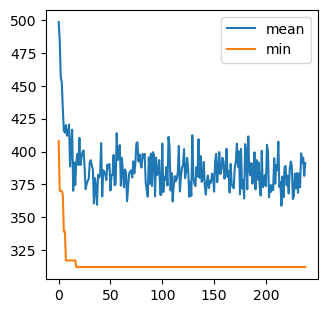

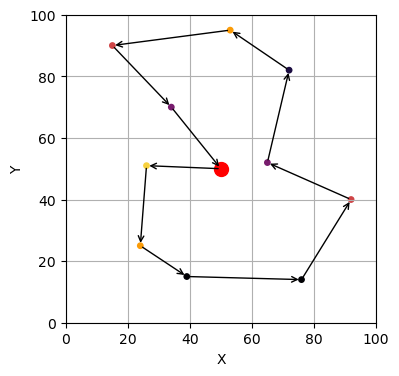

In [464]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.plot(means, label="mean")
ax.plot(mins, label="min")
ax.legend()
best = min(population, key=lambda x: x.fitness.values[0])
plot_route(best, xy_central.T[:11], orders[:11])

In [465]:
best.fitness.values

(312.0,)

In [466]:
#population

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

IND_SIZE = 10

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(1, IND_SIZE+1), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [584]:
def PMX(ind1, ind2):
    ind1 -= 1
    ind2 -= 1
    tools.cxPartialyMatched(ind1, ind2)
    ind1 += 1
    ind2 += 1

    return (ind1, ind2)

def inversion(ind):
    invpoint1 = random.randint(0, len(ind) - 2)
    invpoint2 = random.randint(invpoint1+1, len(ind)-1)
    
    ind[invpoint1:invpoint2+1]=list(reversed(ind[invpoint1:invpoint2+1]))
    
def evaluate(individual, distances, orders, max_capacity=1000):
    dist = distances[0, individual[0]]
    capacity = max_capacity - orders[individual[0]]
    
    for i, f in zip(individual[:-1], individual[1:]):
        if capacity < orders[f]:
            dist += distances[i][0]
            capacity = max_capacity
            dist += distances[0][f]
            # print("Ups, go back")
        else:
            dist += distances[i][f]
        
        capacity -= orders[f]
        # print(f"Went from {i} to {f} and capacity is now {capacity} and dist is {dist}")        
    dist += distances[0, individual[-1]]
    return (dist,)

In [593]:
def many_runs(IND_SIZE,WH,POP_SIZE,ELITIST_CROSS,ELITIST_SIZE,CXPB,MUTPB,INVPB,run):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(1, IND_SIZE+1), IND_SIZE)
    toolbox.register("individual", tools.initIterate, creator.Individual,
                     toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate)
    
    toolbox.register("mate",   PMX)
    #toolbox.register("select", tools.selRoulette) 
    toolbox.register("select", tools.selTournament, tournsize=4) 
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register("invert",inversion)
    
    
    if WH == 'CENTRAL':
        dist=dist_central
    if WH == 'CORNER':
        dist=dist_corner
    
    bests=[]
    bestspop=[]
    for i in range(run):
    
        population = toolbox.population(n=POP_SIZE)

        fitnesses = list(map(lambda I: toolbox.evaluate(I, dist[:IND_SIZE+1], orders[:IND_SIZE+1]), population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Generations     
        g = 0
        means = []
        mins = []
        maxs = []
        while g < 10_000/POP_SIZE:
            g += 1
            # print(f"----- Generation {g} -----")
            population.sort(key=lambda x: x.fitness.values[0])
            offspring = toolbox.select(population[:ELITIST_CROSS*ELITIST_SIZE], len(population)-ELITIST_SIZE)
            offspring = list(map(toolbox.clone, offspring))

                # Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < MUTPB:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values

            for mutant in offspring:
                if random.random() < INVPB:
                    toolbox.invert(mutant)
                    del mutant.fitness.values
            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses   = list(map(lambda I: toolbox.evaluate(I, dist[:IND_SIZE+1], orders[:IND_SIZE+1]), invalid_ind))

            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            population[ELITIST_SIZE:] = offspring
                # Gather all the fitnesses in one list and print the stats
            fits = [ind.fitness.values[0] for ind in population]

            mean = np.mean(fits)
            std  = np.std(fits)
            means.append(mean)
            mins.append(min(fits))
            maxs.append(max(fits))

            #print(f"Min {min(fits)}")
            # print(f"Max {max(fits)}")
            # print(f"Avg {mean}")
            # print(f"Std {std}")
            best = min(population, key=lambda x: x.fitness.values[0])
        bests+=[best.fitness.values]
        bestspop+=[best]
    return bests,bestspop

In [582]:
import collections

## 30 RUNs for 10 customers, WH central

In [597]:
mins,popmins=many_runs(IND_SIZE=10,WH='CENTRAL',POP_SIZE =30,ELITIST_CROSS=3,ELITIST_SIZE = POP_SIZE//5,CXPB = 1,MUTPB = 0.2,INVPB=0.3,run=30)

In [598]:
mins.sort()
print(dict(collections.Counter(mins)))

{(306.0,): 11, (312.0,): 11, (323.0,): 4, (324.0,): 4}


## 30 RUNs for 10 customers, WH corner

In [588]:
mins,popmins=many_runs(IND_SIZE=10,WH='CORNER',POP_SIZE =30,ELITIST_CROSS=3,ELITIST_SIZE = POP_SIZE//5,CXPB = 1,MUTPB = 0.2,INVPB=0.3,run=30)

In [589]:
mins.sort()
print(dict(collections.Counter(mins)))

{(342.0,): 30}


## 30 RUNs for 30 customers, WH corner

In [621]:
mins,popmins=many_runs(IND_SIZE=30,WH='CENTRAL',POP_SIZE =30,ELITIST_CROSS=3,ELITIST_SIZE = POP_SIZE//5,CXPB = 1,MUTPB = 0.2,INVPB=0.3,run=500)

In [622]:
minpop=list(zip(mins,popmins))
mins.sort()
print(dict(collections.Counter(mins)))

{(515.0,): 1, (518.0,): 1, (519.0,): 1, (521.0,): 1, (522.0,): 1, (526.0,): 1, (527.0,): 1, (528.0,): 1, (529.0,): 2, (531.0,): 1, (532.0,): 1, (535.0,): 1, (536.0,): 2, (537.0,): 5, (538.0,): 2, (539.0,): 2, (540.0,): 3, (542.0,): 1, (543.0,): 1, (544.0,): 1, (545.0,): 4, (546.0,): 4, (547.0,): 3, (548.0,): 2, (549.0,): 1, (550.0,): 2, (551.0,): 7, (552.0,): 6, (553.0,): 3, (554.0,): 2, (555.0,): 2, (556.0,): 1, (557.0,): 3, (558.0,): 3, (559.0,): 3, (560.0,): 3, (561.0,): 3, (562.0,): 7, (563.0,): 6, (564.0,): 6, (565.0,): 1, (566.0,): 8, (567.0,): 3, (568.0,): 6, (569.0,): 5, (570.0,): 1, (571.0,): 8, (572.0,): 3, (573.0,): 3, (574.0,): 5, (575.0,): 5, (576.0,): 5, (577.0,): 6, (578.0,): 4, (579.0,): 6, (580.0,): 5, (581.0,): 5, (582.0,): 3, (583.0,): 4, (584.0,): 4, (585.0,): 4, (586.0,): 5, (587.0,): 5, (588.0,): 3, (589.0,): 8, (590.0,): 3, (591.0,): 6, (592.0,): 3, (593.0,): 5, (594.0,): 3, (595.0,): 4, (596.0,): 5, (597.0,): 5, (598.0,): 7, (599.0,): 7, (601.0,): 3, (602.0,): 6

In [626]:
bla=[ 8,  5, 19, 21, 30,  7, 20,  4, 17, 28, 26, 13, 24, 29, 16,
             1, 22, 15, 10, 12, 25,  2, 14,  3, 11,  9, 23, 18,  6, 27]

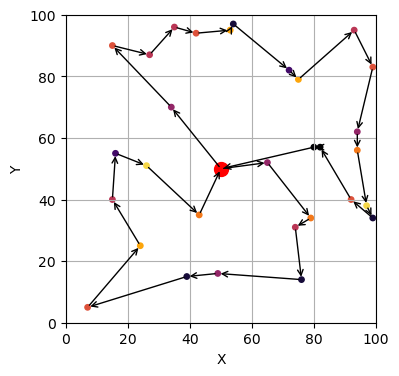

In [630]:
plot_route(bla, xy_central.T[:31], orders[:31])

## 30 RUNS for 30 customers, WH CORNER

In [632]:
mins2,popmins2=many_runs(IND_SIZE=30,WH='CORNER',POP_SIZE =30,ELITIST_CROSS=3,ELITIST_SIZE = POP_SIZE//5,CXPB = 1,MUTPB = 0.2,INVPB=0.3,run=500)

In [633]:
minpop2=list(zip(mins2,popmins2))
mins2.sort()
print(dict(collections.Counter(mins2)))

{(616.0,): 2, (617.0,): 1, (618.0,): 3, (619.0,): 2, (620.0,): 1, (623.0,): 1, (625.0,): 2, (626.0,): 2, (627.0,): 1, (628.0,): 1, (629.0,): 2, (630.0,): 3, (631.0,): 1, (632.0,): 1, (633.0,): 4, (634.0,): 1, (635.0,): 2, (636.0,): 2, (637.0,): 1, (638.0,): 2, (639.0,): 7, (640.0,): 1, (641.0,): 3, (642.0,): 2, (644.0,): 4, (645.0,): 1, (647.0,): 5, (648.0,): 4, (649.0,): 9, (650.0,): 2, (651.0,): 3, (652.0,): 3, (653.0,): 3, (654.0,): 3, (655.0,): 5, (656.0,): 5, (657.0,): 3, (658.0,): 2, (659.0,): 3, (660.0,): 6, (661.0,): 6, (662.0,): 3, (663.0,): 5, (664.0,): 2, (665.0,): 6, (666.0,): 7, (667.0,): 6, (668.0,): 6, (669.0,): 4, (670.0,): 1, (671.0,): 8, (672.0,): 5, (673.0,): 1, (674.0,): 4, (675.0,): 3, (676.0,): 5, (677.0,): 6, (678.0,): 6, (679.0,): 7, (680.0,): 4, (681.0,): 4, (682.0,): 8, (683.0,): 5, (684.0,): 3, (685.0,): 2, (686.0,): 3, (687.0,): 2, (688.0,): 4, (689.0,): 5, (690.0,): 8, (691.0,): 4, (692.0,): 1, (693.0,): 2, (694.0,): 6, (695.0,): 9, (696.0,): 5, (697.0,): 3

In [638]:
blah=0
for i in range(len(minpop2)):
    if minpop2[i][0]==(616.0,):
        blah=i

In [639]:
minpop2[blah]

((616.0,),
 Individual([23,  6, 18,  8, 19,  5, 21, 30, 20,  7,  4, 17, 28, 26, 13,
             24,  1, 12, 25,  9, 11,  3, 14,  2, 16, 29, 22, 15, 10, 27]))

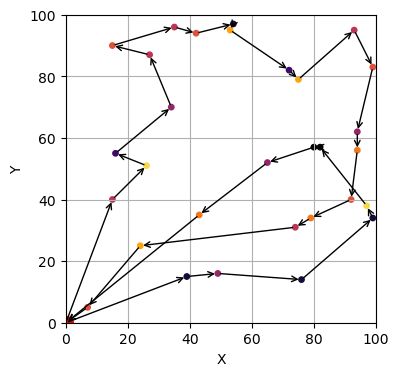

In [641]:
plot_route([23,  6, 18,  8, 19,  5, 21, 30, 20,  7,  4, 17, 28, 26, 13, 
            24,  1, 12, 25,  9, 11,  3, 14,  2, 16, 29, 22, 15, 10, 27], 
           xy_corner.T[:31], orders[:31])

In [642]:
mins3,popmins3=many_runs(IND_SIZE=30,WH='CORNER',POP_SIZE =30,ELITIST_CROSS=3,ELITIST_SIZE = POP_SIZE//5,CXPB = 1,MUTPB = 0.2,INVPB=0.3,run=30)

In [643]:
minpop3=list(zip(mins3,popmins3))
mins3.sort()
print(dict(collections.Counter(mins3)))

{(613.0,): 1, (618.0,): 1, (626.0,): 1, (633.0,): 1, (643.0,): 1, (647.0,): 1, (652.0,): 1, (656.0,): 1, (660.0,): 1, (662.0,): 1, (670.0,): 1, (674.0,): 1, (675.0,): 1, (679.0,): 1, (683.0,): 1, (685.0,): 1, (688.0,): 1, (705.0,): 2, (708.0,): 1, (711.0,): 2, (723.0,): 1, (732.0,): 1, (735.0,): 1, (737.0,): 1, (754.0,): 1, (757.0,): 1, (762.0,): 1, (810.0,): 1}


In [645]:
blah=0
for i in range(len(minpop3)):
    if minpop3[i][0]==(613.0,):
        blah=i

In [646]:
minpop3[blah]

((613.0,),
 Individual([15, 22, 24, 13, 26, 28, 17,  4, 20,  7, 30, 21,  5, 19,  8,
             18,  6, 23, 11,  9, 27, 10, 25, 12,  1, 29, 16,  2, 14,  3]))

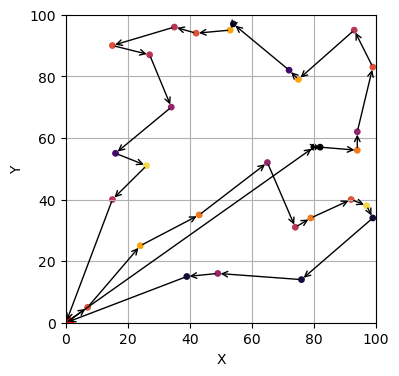

In [647]:
plot_route([15, 22, 24, 13, 26, 28, 17,  4, 20,  7, 30, 21,  5, 19,  8,
             18,  6, 23, 11,  9, 27, 10, 25, 12,  1, 29, 16,  2, 14,  3], 
           xy_corner.T[:31], orders[:31])

## Reminder: Falta fazer com orders constantes = 50 !!